For cases where the ground truth free water volume fraction is near to one (i.e. voxels that basically containing free water), the tissue's diffusion tensor component can erroneously fit the free water diffusion signal and therefore the free water DTI model fails to identifying the signal as pure free water. In these cases, since both tissue and free water compartment represent well the signal, the free water volume fraction can be arbitrarily estimated to any value of the range between 0 and 1 rather than being close to 1.

In their paper, Hoy et al. (2014) mentioned that this issue effects data with free water volume fractions ground truth larger than 0.7. Parameter estimates for this data were also mentioned to be associated to underestimated water volume fraction estimates (particularly f < 0.05) and overestimated tissue mean diffusion what approaches the values of free water diffusion (i.e. $3.0 \times 10 ^{-3} mm^2/s$). For this reason, to mitigate these estimates, Hoy et al. (2014) proposed to half the tissue's diffusion tensor and reset f to 0.5 before performing the non-linear procedure to overcome these fitting erro when the tissue's mean diffusivity is above $1.5 \times 10 ^{-3} mm^2/s$.

In this notebook, the initialization criteria proposed by Hoy et al. (2014) is evaluated by accessing the values of mean diffusivity for voxels that only contain free water (i.e. ground truth f = 1). The frequency that tissue's compartment overfits the other high free water volume fractions (f>0.7) is then accessed. Finally, based on the observation done here, the criteria to overcome high ground truth f issue is re-adjusted.

Relevant modules are first imported:

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
import time
import sys
import os 
%matplotlib inline

# Change directory to the code folder
os.chdir('..//code')

# Functions to sample the diffusion-weighted gradient directions
from dipy.core.sphere import disperse_charges, HemiSphere

# Function to reconstruct the tables with the acquisition information
from dipy.core.gradients import gradient_table

# Functions to perform simulations based on multi-compartment models
from dipy.sims.voxel import multi_tensor

# Import Dipy's procedures to process diffusion tensor
import dipy.reconst.dti as dti

# Importing procedures to fit the free water elimination DTI model
from functions import (wls_fit_tensor, nls_fit_tensor)

Below we define the simulated acquisition parameters:

In [2]:
# Sample the spherical cordinates of 32 random diffusion-weighted
# directions.
n_pts = 32
theta = np.pi * np.random.rand(n_pts)
phi = 2 * np.pi * np.random.rand(n_pts)

# Convert direction to cartesian coordinates. For this, Dipy's
# class object HemiSphere is used. Since diffusion possess central
# symmetric, this class object also projects the direction to an 
# Hemisphere. 
hsph_initial = HemiSphere(theta=theta, phi=phi)

# By using a electrostatic potential energy algorithm, the directions
# of the HemiSphere class object are moved util them are evenly
# distributed in the Hemi-sphere
hsph_updated, potential = disperse_charges(hsph_initial, 5000)
directions = hsph_updated.vertices

# Based on the evenly sampled directions, the acquistion parameters are
# simulated. Vector bvals containts the information of the b-values
# while matrix bvecs contains all gradient directions for all b-value repetitions.
bvals = np.hstack((np.zeros(6), 500 * np.ones(n_pts), 1500 * np.ones(n_pts)))
bvecs = np.vstack((np.zeros((6, 3)), directions, directions))

# bvals and bvecs are converted according to Dipy's accepted format using
# Dipy's function gradient_table
gtab = gradient_table(bvals, bvecs)


# Simulations are runned for the SNR defined according to Hoy et al, 2014
SNR = 40

Next the ground truth values of tissue and water diffusion are defined. Simulations are first run for a voxel containing only water for the extreme FA values.

For this notebook, the percentage of low volume fraction estimates are accessed for the extreme FA values and ground truth water volume fractions larger that 50% since this issue arised for high f values. Here we also analyse the percentage of low estimated volume fractions for ground water volume fraction sampled using a smaller step size of 0.05.  

In [3]:
# Setting the volume fraction (VF) to 100%. 
VF = 100

# The value of free water diffusion is set to its known value 
Dwater = 3e-3

# Simulations are repeated for 5 levels of fractional anisotropy
FA = np.array([0.71, 0.])
L1 = np.array([1.6e-3, 0.8e-03])
L2 = np.array([0.5e-3, 0.8e-03])
L3 = np.array([0.3e-3, 0.8e-03])

# According to Hoy et al., simulations are repeated for 120 different
# diffusion tensor directions (and each direction repeated 100 times).
nDTdirs = 120
nrep = 100

# These directions are sampled using the same procedure used
# to evenly sample the diffusion gradient directions
theta = np.pi * np.random.rand(nDTdirs)
phi = 2 * np.pi * np.random.rand(nDTdirs)
hsph_initial = HemiSphere(theta=theta, phi=phi)
hsph_updated, potential = disperse_charges(hsph_initial, 5000)
DTdirs = hsph_updated.vertices

Having the parameters set, the simulations are processed below:

In [4]:
# Initializing a matrix to save all synthetic diffusion-weighted
# signals. Each dimension of this matrix corresponds to the number
# of simulated FA levels, free water volume fractions,
# diffusion tensor directions, and diffusion-weighted signals
# of the given gradient table
DWI_simulates = np.empty((FA.size, 1, nrep * nDTdirs, bvals.size))

for fa_i in range(FA.size):

    # selecting the diffusion eigenvalues for a given FA level
    mevals = np.array([[L1[fa_i], L2[fa_i], L3[fa_i]],
                       [Dwater, Dwater, Dwater]])

    # estimating volume fractions for both simulations
    # compartments (in this case 0 and 100)
    fractions = [100 - VF, VF]

    for di in range(nDTdirs):

        # Select a diffusion tensor direction
        d = DTdirs[di]

        # Repeat simulations for the given directions
        for s_i in np.arange(di * nrep, (di+1) * nrep):
            # Multi-compartmental simulations are done using
            # Dipy's function multi_tensor
            signal, sticks = multi_tensor(gtab, mevals,
                                          S0=100,
                                          angles=[d, (1, 0, 0)],
                                          fractions=fractions,
                                          snr=SNR)
            DWI_simulates[fa_i, 0, s_i, :] = signal
    prog = (fa_i+1.0) / FA.size * 100
    time.sleep(1)
    sys.stdout.write("\r%f%%" % prog)
    sys.stdout.flush()

100.000000%

To analyse the issue before its correction, the small volume fractions estimates are analysed at the parameters initial estimation using the wls procedure and turning the parameter reinitialization off (mdreg=None).

In [5]:
t0 = time.time()
fw_params = wls_fit_tensor(gtab, DWI_simulates, Diso=Dwater,
                           mdreg=None)
dt = time.time() - t0
print("This step took %f seconds to run" % dt)

This step took 23.055000 seconds to run


Below the histograms of the tensor's mean diffusivity and volume fraction estimates are computed. Additionally, the estimates of tensor's mean diffusivity as a function of the estimated volume fraction is plotted. Upper and lower panels corresponds to the higher and lower FA value tested.

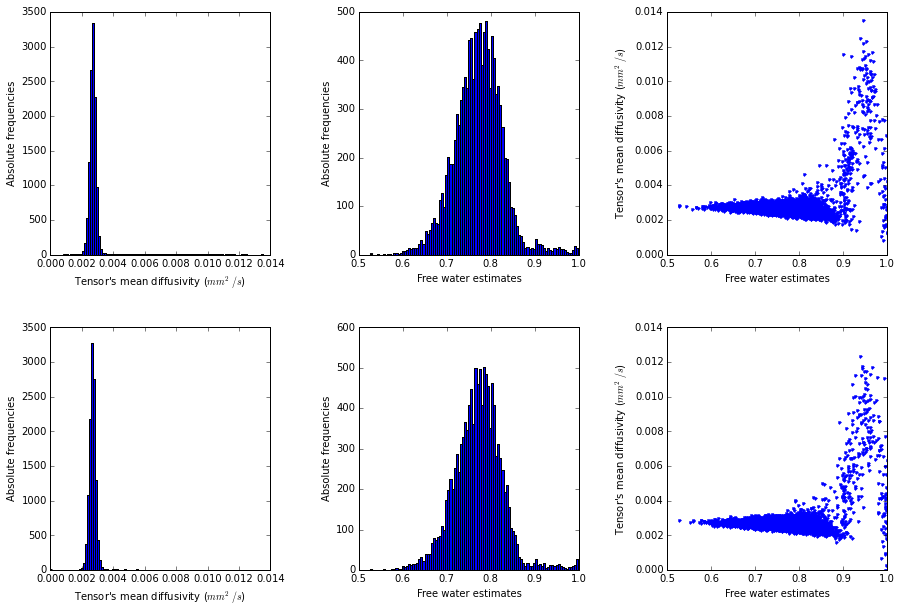

In [6]:
fig, axs = plt.subplots(nrows=2, ncols=3, figsize=(15, 10))
fig.subplots_adjust(hspace=0.3, wspace=0.4)

# Compute the tissue's diffusion tensor mean diffusivity
# using the functions mean_diffusivity of Dipy's module dti
md = dti.mean_diffusivity(fw_params[..., :3])

# Extract the water volume fraction estimates from the fitted
# model parameters
f = fw_params[..., 12]

# Defining the colors of the figure
colors = {0: 'r', 1: 'g'}

# Plot figures for both FA extreme levels (0 and 0.71)
for fa_i in range(FA.size):

    # Set histogram's number of bins
    nbins = 100

    # Plot tensor's mean diffusivity histograms
    axs[fa_i, 0].hist(md[fa_i, 0, :], nbins)
    axs[fa_i, 0].set_xlabel("Tensor's mean diffusivity ($mm^2/s$)")
    axs[fa_i, 0].set_ylabel('Absolute frequencies')

    # Plot water volume fraction histograms
    axs[fa_i, 1].hist(f[fa_i, 0, :], nbins)
    axs[fa_i, 1].set_xlabel('Free water estimates')
    axs[fa_i, 1].set_ylabel('Absolute frequencies')

    # Plot mean diffusivity as a function of f estimates
    axs[fa_i, 2].plot(f[fa_i, 0, :].ravel(), md[fa_i, 0, :].ravel(), '.')
    axs[fa_i, 2].set_xlabel('Free water estimates')
    axs[fa_i, 2].set_ylabel("Tensor's mean diffusivity ($mm^2/s$)")

# Save Figure
fig.savefig('Pure_free_water_F_and_tensor_MD_estimates.png')

The above figure shows that pure free water signals produce tensor's mean diffusivity is almost always larger than $2.0 \times 10 ^{-3} mm^2/s$ (left panels). Therefore, the threshold of $1.5 \times 10 ^{-3} mm^2/s$ proposed by Hoy et al. (2014) seems more than adequate to identifying voxels that contain mostly free water. It is also important to note that this threshold should not affect plausible mean diffusivity estimates with small free water contaminations because typical tissue's mean diffusivity have values that are two times smaller than this threshold.

In opposite to what was reported by Hoy et al. (2014), no free water volume fractions estimate smaller than 0.05 was observed when only free water is present, instead their estimates ranged from 0.55 to 1.00 (middle panels). In this way, reinitializing the free water volume fraction to 0.5 should not be adequate - voxels likely related to high free water contamination should be readjusted to higher volume fractions rather than to lower values.

For volume fractions higher than 0.9, the low contribution of the tissue's compartment $(1-f)$ seems to produces random implausible tensor's mean diffusivity values larger than the value of free water diffusion. Therefore, halving the tissue's diffusion tensor might not be enough to avoid problematic estimates in the non-linear fitting procedure. 

All observations are applicable for both FA values tested (0.71 and 0 for upper and lower panels).

Below the frequency that tissue's mean diffusivity is overestimated to values larger than Hoy et al. (2014) criteria from volume fractions higher than 0.7 is accessed.

In [7]:
# Sampling the free water volume fraction between 70% and 100%. 
VF = np.linspace(70, 100, 31)

Simulations are rerun for the resampled ground truth free water volume fraction

In [9]:
# Initializing a matrix to save all synthetic diffusion-weighted
# signals. Each dimension of this matrix corresponds to the number
# of simulated FA levels, volume fractions, diffusion tensor
# directions, and diffusion-weighted signals of the given
# gradient table
DWI_simulates = np.empty((FA.size, VF.size, nrep * nDTdirs,
                          bvals.size))

for fa_i in range(FA.size):

    # selecting the diffusion eigenvalues for a given FA level
    mevals = np.array([[L1[fa_i], L2[fa_i], L3[fa_i]],
                       [Dwater, Dwater, Dwater]])

    for vf_i in range(VF.size):

        # estimating volume fractions for both simulations
        # compartments
        fractions = [100 - VF[vf_i], VF[vf_i]]

        for di in range(nDTdirs):

            # Select a diffusion tensor direction
            d = DTdirs[di]

            # Repeat simulations for the given directions
            for s_i in np.arange(di * nrep, (di+1) * nrep):
                # Multi-compartmental simulations are done using
                # Dipy's function multi_tensor
                signal, sticks = multi_tensor(gtab, mevals,
                                              S0=100,
                                              angles=[d, (1, 0, 0)],
                                              fractions=fractions,
                                              snr=SNR)
                DWI_simulates[fa_i, vf_i, s_i, :] = signal
        prog = (fa_i+1.0) * (vf_i+1.0) / (FA.size * VF.size) * 100
        time.sleep(1)
        sys.stdout.write("\r%f%%" % prog)
        sys.stdout.flush()

100.000000%

The parameters initial estimation is processed for the ground trutg volume fraction from 0.7 to 1 using the wls procedure and turning the parameter reinitialization off (mdreg=None).

In [10]:
t0 = time.time()
fw_params = wls_fit_tensor(gtab, DWI_simulates, Diso=Dwater,
                           mdreg=None)
dt = time.time() - t0
print("This step took %f seconds to run" % dt)

This step took 513.177000 seconds to run


Below the percentage of parameter estimates with tensor's mean diffusivity higher than $2.0 \times 10 ^{-3} mm^2/s$ are plotted as a function of the f ground truth values for the higher (left panel) and lower (right panel) fractional anisotropy levels.

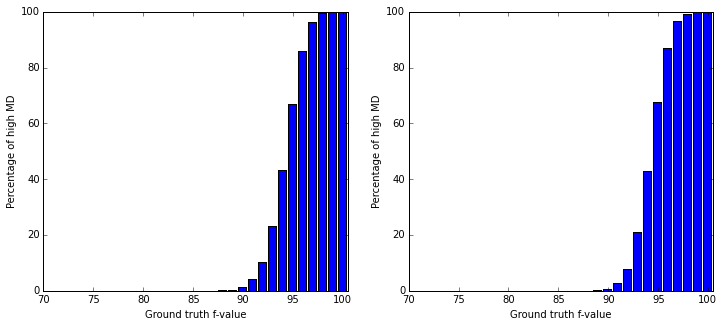

In [11]:
fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(12, 5))

# Compute the tissue's compartment mean diffusivity
# using function mean_diffusivity of Dipy's module dti
md = dti.mean_diffusivity(fw_params[..., :3])

# Set the md threshold to classify overestimated values
# of md
md_th = 1.5e-3;

# Initializing vector to save the percentage of high
# md values
p_high_md = np.empty(VF.size)

# Position of bar

for fa_i in range(FA.size):
    for vf_i in range(VF.size):

        # Select the mean diffusivity values for the given
        # water volume fraction and FA level 
        md_vector = md[fa_i, vf_i, :].ravel()
        p_high_md[vf_i] = (sum(md_vector > md_th) * 100.0) / (nrep*nDTdirs) 

    # Plot FA statistics as a function of the ground truth 
    # water volume fraction. Note that position of bars are
    # shifted by 0.5 so that centre of bars correspond to the
    # ground truth volume fractions
    axs[fa_i].bar(VF - 0.5, p_high_md)
    
    # Adjust properties of panels
    axs[fa_i].set_xlim([70, 100.5])
    axs[fa_i].set_ylim([0, 100])
    axs[fa_i].set_xlabel('Ground truth f-value')
    axs[fa_i].set_ylabel('Percentage of high MD')

# Save figure
fig.savefig('Percentage_High_MD.png')

From the figure above, only water volume fractions larger than 90% showed inflated tensor's mean diffusivity over $1.5 \times 10 ^{-3} mm^2/s$. 

Given the two figures above, the following adjustments were done in parameters reinitialization before the use of the non-linear fitting procedure:

1) Free water volume fraction estimates are set to 1 rather than 0.5 when tissue's mean diffusivity is higher than $1.5 \times 10 ^{-3} mm^2/s$, since this voxels have a large propability of being associated to voxels mostly contain free water

2) To avoid high tissue's mean diffusivity for high volume fraction estimates and better indicate that tissue diffusion is particaly absent for these cases, the elements of the tissues diffusion tensor is set zero (corresponding to tissue's MD = $0 \times 10 ^{-3} mm^2/s$ and FA = 0)